In [28]:
cd ../../../scripts/Learn_DMP/


/home/tanmay/Research/Code/ActionPrimitives/scripts/Learn_DMP


In [29]:
from headers import *

Defining a Class for DMPs

In [30]:
class DMP():
	
	def __init__(self):

		self.alphaz = 25.0
		self.betaz = self.alphaz/4
		self.alpha = 1*self.alphaz/3    
        
		self.time_steps = 100
		self.tau = self.time_steps

		self.dimensions = 2
		self.number_kernels = 100
		self.gaussian_kernels = npy.zeros((self.number_kernels,2))

		self.weights = npy.zeros((self.number_kernels, self.dimensions))

		self.demo_pos = npy.zeros((self.time_steps, self.dimensions))
		self.demo_vel = npy.zeros((self.time_steps, self.dimensions))
		self.demo_acc = npy.zeros((self.time_steps, self.dimensions))

		self.target_forces = npy.zeros((self.time_steps, self.dimensions))        
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))
		self.vector_phase = npy.zeros(self.time_steps)
        
# Defining Linear Phase Variables.        
		self.linear_vector_phase = npy.zeros(self.time_steps)
		self.linear_eta = npy.zeros((self.time_steps,self.dimensions))
		self.linear_weights = npy.zeros((self.number_kernels,self.dimensions))
		self.linear_forces = npy.zeros((self.time_steps,self.dimensions))
                
# Defining Rollout variables.
		self.rollout_time = self.time_steps
		self.dt = 1./self.rollout_time
		self.pos_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.acc_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.force_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.pos_var = npy.zeros(self.dimensions)
		self.vel_var = npy.zeros(self.dimensions)
		self.acc_var = npy.zeros(self.dimensions)        
		self.force_var = npy.zeros(self.dimensions)        
		self.goal = npy.zeros(self.dimensions)
		self.start = npy.zeros(self.dimensions)        

	def load_trajectory(self,pos,vel,acc):
		self.demo_pos = copy.deepcopy(pos)
		self.demo_vel = copy.deepcopy(vel)
		self.demo_acc = copy.deepcopy(acc)

	def initialize_variables(self):	
		self.weights = npy.zeros((self.number_kernels, self.dimensions))
		self.target_forces = npy.zeros((self.time_steps, self.dimensions))
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))

		t_range = npy.linspace(0,self.time_steps,self.number_kernels)
# 		t_range_2 = npy.linspace(0,self.time_steps,self.time_steps)        
		self.vector_phase = self.calc_vector_phase(t_range)
		self.gaussian_kernels[:,0] = self.vector_phase
        
# Experiment with the variance of the Guassian Kernels.
# Higher variance helps reach the target values more accurately. 
# The rolled out trajectory is worse. 

# FIND OUT THE DIFFERENCE BETWEEN THE PLOTTED RECONSTRUCTED AND ROLLOUT FORCES.
		self.gaussian_kernels[:,1] = self.number_kernels/self.gaussian_kernels[:,0]

	def calc_phase(self,time):
		return npy.exp(-self.alpha*float(time)/self.tau)

	def linear_phase(self,time):
		return 1.-float(time)/self.tau
    
	def calc_linear_vector_phase(self,time):
		return 1.-time.astype(float)/self.tau

	def calc_vector_phase(self,time):
		return npy.exp(-self.alpha*time.astype(float)/self.tau)
    
	def basis(self,index,time):
		return npy.exp(-(self.gaussian_kernels[index,1])*((self.calc_phase(time)-self.gaussian_kernels[index,0])**2))

	def update_target_force(self):
		self.target_forces = self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel)
    
  	def update_target_force_itau(self):
		self.target_forces = (self.tau**2)*self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.tau*self.demo_vel)
        
  	def update_target_force_dtau(self):
		self.target_forces = self.demo_acc/(self.tau**2) - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel/self.tau)    

	def update_phi(self):		
		for i in range(self.number_kernels):
			for t in range(self.time_steps):
				self.phi[i,t,t] = self.basis(i,t)                
                
	def update_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		vector_phase = self.calc_vector_phase(t_range)        
		self.eta[:,0] = vector_phase*(self.demo_pos[self.time_steps-1,0]-self.demo_pos[0,0])
		self.eta[:,1] = vector_phase*(self.demo_pos[self.time_steps-1,1]-self.demo_pos[0,1])

	def update_linear_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		self.linear_vector_phase = self.calc_linear_vector_phase(t_range)        
# 		self.linear_eta[:,0] = self.linear_vector_phase*(self.demo_pos[self.time_steps-1,0]-self.demo_pos[0,0])
# 		self.linear_eta[:,1] = self.linear_vector_phase*(self.demo_pos[self.time_steps-1,1]-self.demo_pos[0,1])
		self.linear_eta[:,0] = (self.demo_pos[self.time_steps-1,0]-self.demo_pos[0,0])
		self.linear_eta[:,1] = (self.demo_pos[self.time_steps-1,1]-self.demo_pos[0,1])
    
	def learn_DMP(self):	
# 		self.update_target_force()        
		self.update_phi()
		self.update_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.weights[i,j] = npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.weights[i,j] /= npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.eta[:,j]))

	def learn_linear_DMP(self):	
# 		self.update_target_force()        
# 		self.update_phi()
		self.update_linear_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.linear_weights[i,j] = npy.dot(self.linear_eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.linear_weights[i,j] /= npy.dot(self.linear_eta[:,j],npy.dot(self.phi[i],self.linear_eta[:,j]))                
                
	def save_DMP_parameters(self,file_suffix):

		with file("force_weights_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile,self.weights)
	
		with file("position_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile, self.demo_pos)
            
	def shebang(self,pos,vel,acc):
		dmp.load_trajectory(pos,vel,acc)
		dmp.initialize_variables()
		dmp.learn_DMP()
		dmp.learn_linear_DMP()        
        
	def initialize_rollout(self,start,goal):
		self.tau = 1
		self.pos_var = copy.deepcopy(start)
		self.pos_roll[0] = copy.deepcopy(start)
		self.vel_var = npy.zeros(self.dimensions)
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.goal = goal
		self.start = start
		self.dt = 1./self.rollout_time    

	def calc_rollout_force(self,roll_time):
		den = 0        
		time = float(roll_time)/self.rollout_time           
		print(roll_time,time,self.calc_phase(time),self.tau)
		for i in range(self.number_kernels):
			self.force_roll[roll_time] += self.basis(i,time)*self.weights[i]
			den += self.basis(i,time)
		self.force_roll[roll_time] *= (self.goal-self.pos_roll[0])*self.calc_phase(time)/den
            
	def calc_rollout_acceleration(self,time):        
		self.acc_var = (1/self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_var) - self.tau*self.vel_var) + self.force_roll[time])
		self.acc_roll[time] = copy.deepcopy(self.acc_var)
        
	def calc_rollout_vel(self,time):
		self.vel_var += (1/self.tau)*self.acc_var*self.dt
		self.vel_roll[time] = copy.deepcopy(self.vel_var)

	def calc_rollout_pos(self,time):
		self.pos_var += self.vel_var * self.dt
		self.pos_roll[time] = copy.deepcopy(self.pos_var)

	def rollout(self,start,goal):

		# For all time: 
		self.initialize_rollout(start,goal)
		for i in range(self.rollout_time):        
			self.calc_rollout_force(i)
			self.calc_rollout_acceleration(i)
			self.calc_rollout_vel(i)
			self.calc_rollout_pos(i)   

In [31]:
cd ../../Data/Mouse_Data_New/Traj_0/

/home/tanmay/Research/Code/ActionPrimitives/Data/Mouse_Data_New/Traj_0


In [32]:
dmp = DMP()	
pos = npy.load("pos_0.npy")
vel = npy.load("vel_0.npy")
acc = npy.load("acc_0.npy")

# t1 = 50
# t2 = t1+100
# pos = pos[t1:t2]
ts = 1000
# vel = ts*vel[t1:t2]
# acc = (ts**2)*acc[t1:t2]

pos = pos[::10]
vel = ts*vel[::10]
acc = (ts**2)*acc[::10]
# vel *= ts
# acc *= ts**2

# # pos = npy.load("position_18.npy")
# # vel = npy.load("velocity_18.npy")
# # acc = npy.load("acceleration_18.npy")

# # dmp.load_trajectory(pos,vel,acc)
# # dmp.initialize_variables()
# # # dmp.update_target_force()
# # dmp.update_target_force_dtau()
# # dmp.learn_DMP()

# # tr = npy.linspace(0,99,100)
# # plt.plot(tr, dmp.target_forces)
# # plt.title("With TAU")
# # plt.show()

In [33]:
pos.shape,vel.shape,acc.shape

((100, 2), (100, 2), (100, 2))

In [34]:
# dmp = DMP()	
# pos = npy.load("position1.npy")
# vel = npy.load("velocity1.npy")
# acc = npy.load("acceleration1.npy")

# pos[:,1] = -pos[:,1]
dmp.load_trajectory(pos,vel,acc)
# dmp.load_trajectory(pos,vel,acc)
dmp.initialize_variables()
# dmp.update_target_force()
# dmp.update_target_force_itau()
dmp.update_target_force_dtau()
dmp.learn_DMP()
dmp.learn_linear_DMP()

# tr = npy.linspace(0,99,100)
tr = npy.linspace(0,dmp.time_steps-1,dmp.time_steps)
# plt.plot(tr, dmp.target_forces)
# plt.title("Without Tau")
# plt.show()

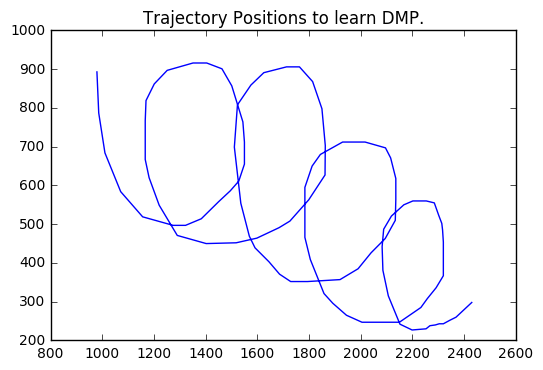

In [35]:
plt.plot(dmp.demo_pos[:,0],dmp.demo_pos[:,1])
# plt.title("Trajectory : Position.")
# plt.plot(dmp.demo_pos[change_ind,0],dmp.demo_pos[change_ind,1],'o')
plt.title("Trajectory Positions to learn DMP.")
plt.show()

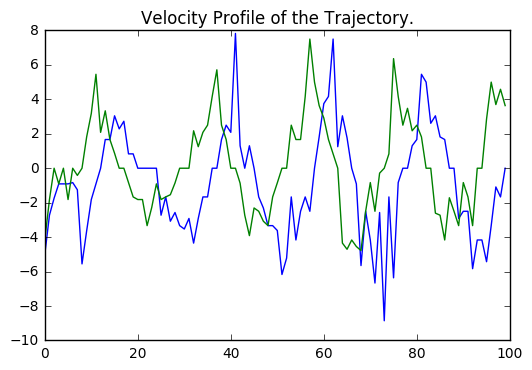

In [36]:
# plt.plot(dmp.demo_pos[:,0],dmp.demo_pos[:,1])
# plt.plot(range(100),dmp.demo_pos)
# plt.plot(range(100),dmp.demo_vel)
plt.plot(range(dmp.time_steps),dmp.demo_vel/dmp.tau)
plt.title("Velocity Profile of the Trajectory.")
plt.show()

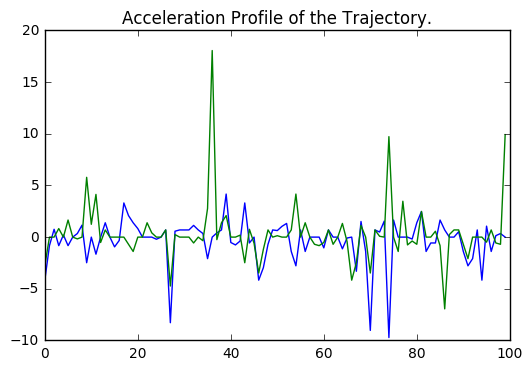

In [37]:
# plt.plot(range(100),dmp.demo_acc)
plt.plot(range(dmp.time_steps),dmp.demo_acc/dmp.tau**2)
plt.title("Acceleration Profile of the Trajectory.")
plt.show()

# npy.where(abs(dmp.demo_acc[:,0]/(dmp.tau**2))>0.5),npy.where(abs(dmp.demo_acc[:,1]/(dmp.tau**2))>0.5)

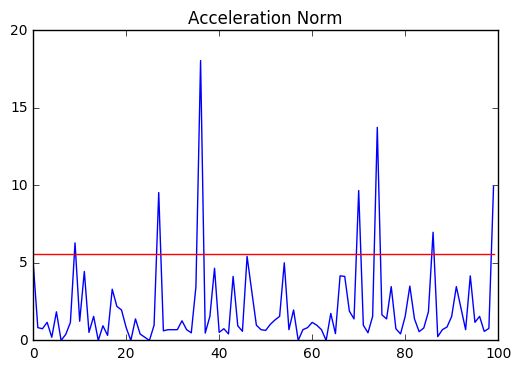

In [38]:
norm_acc = npy.linalg.norm(dmp.demo_acc/(dmp.tau**2),axis=1)
plt.plot(range(dmp.time_steps),norm_acc,'b')
plt.plot(range(dmp.time_steps),2.7*norm_acc.mean()*npy.ones(dmp.time_steps),'r')
plt.title("Acceleration Norm")
plt.show()

change_ind = npy.where(norm_acc>(3.5*norm_acc.mean()))

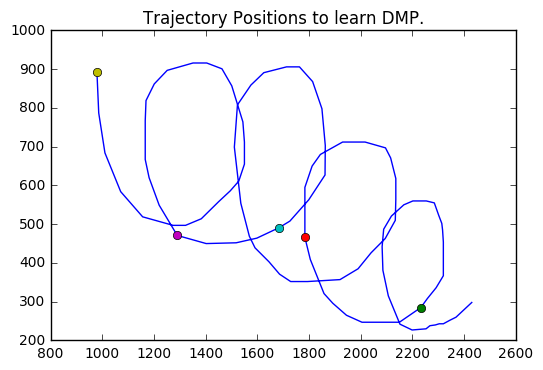

In [39]:
plt.plot(dmp.demo_pos[:,0],dmp.demo_pos[:,1])
# plt.title("Trajectory : Position.")
plt.plot(dmp.demo_pos[change_ind,0],dmp.demo_pos[change_ind,1],'o')
plt.title("Trajectory Positions to learn DMP.")
plt.show()

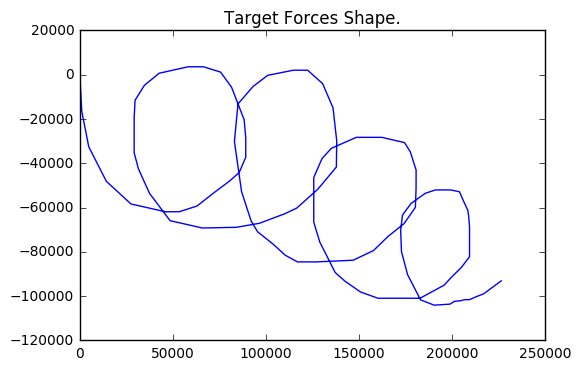

In [40]:
plt.plot(dmp.target_forces[:,0],dmp.target_forces[:,1])
plt.title("Target Forces Shape.")
plt.show()

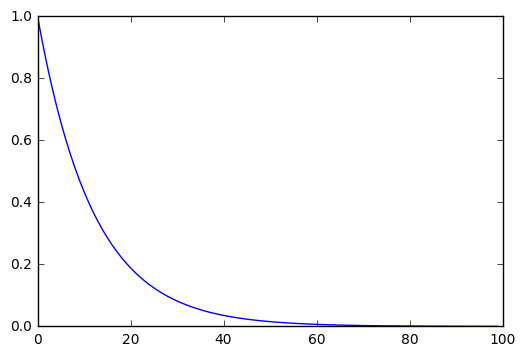

100

In [41]:
dmp.tau = 100

pval = npy.zeros(dmp.time_steps)
for i in range(dmp.time_steps):
    pval[i] = dmp.calc_phase(float(i))
plt.plot(range(dmp.time_steps),pval)
plt.show()

dmp.tau

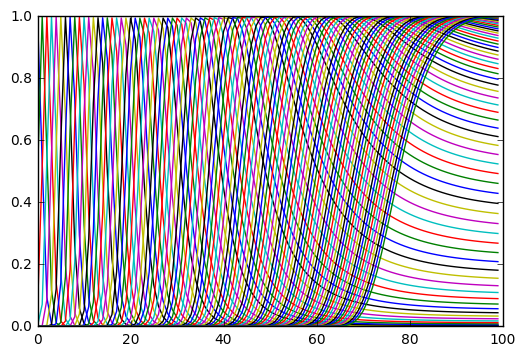

In [42]:
b = npy.zeros((dmp.number_kernels,dmp.time_steps))
# dmp.tau = 100
# dmp.gaussian_kern
for i in range(dmp.number_kernels):
# for i in range(100):
    for t in range(dmp.time_steps):
        b[i,t]=dmp.basis(i,t)        
    plt.plot(tr,b[i])    

plt.show()
# dmp.tau =100 

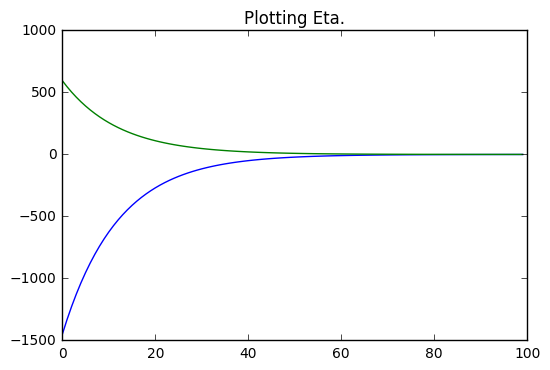

In [43]:
plt.plot(range(dmp.time_steps),dmp.eta)
plt.title("Plotting Eta.")
plt.show()

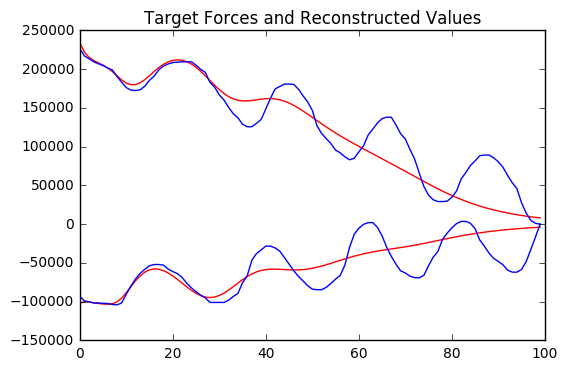

In [44]:
force = npy.zeros((dmp.time_steps,2))
dmp.goal = copy.deepcopy(dmp.demo_pos[dmp.time_steps-1])

for t in range(dmp.time_steps):
    den = 0
    for i in range(dmp.number_kernels):
        force[t] += dmp.weights[i]*dmp.basis(i,t)
        den += dmp.basis(i,t)    
    force[t,0]*=(dmp.goal[0]-dmp.demo_pos[0,0])*dmp.calc_phase(t)/den
    force[t,1]*=(dmp.goal[1]-dmp.demo_pos[0,1])*dmp.calc_phase(t)/den
    
# plt.plot(tr,force)
# plt.show()

plt.plot(tr,force,'r',label='Reconstructed Forces')
plt.plot(tr,dmp.target_forces,'b',label='Target Forces')
# t=2
# plt.plot([t,t],[-600,0],'g')
plt.title("Target Forces and Reconstructed Values")
# plt.legend()
plt.show()

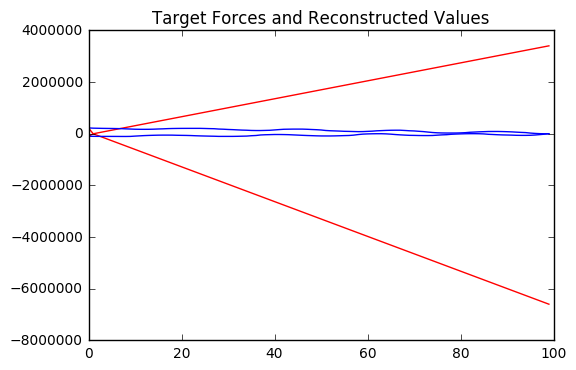

In [54]:
force2 = npy.zeros((dmp.time_steps,2))
dmp.goal = copy.deepcopy(dmp.demo_pos[dmp.time_steps-1])

for t in range(dmp.time_steps):
    den = 0
    for i in range(dmp.number_kernels):
        force2[t] += dmp.linear_weights[i]*dmp.basis(i,t)
        den += dmp.basis(i,t)    
#     force2[t,0]*=(dmp.goal[0]-dmp.demo_pos[0,0])*dmp.linear_phase(t)/den
#     force2[t,1]*=(dmp.goal[1]-dmp.demo_pos[0,1])*dmp.linear_phase(t)/den
    force2[t,0]*=(dmp.goal[0]-dmp.demo_pos[0,0])*dmp.linear_phase(t)/den
    force2[t,1]*=(dmp.goal[1]-dmp.demo_pos[0,1])*dmp.linear_phase(t)/den
    
# plt.plot(tr,force)
# plt.show()

plt.plot(tr,force2,'r',label='Reconstructed Forces')
plt.plot(tr,dmp.target_forces,'b',label='Target Forces')
# t=2
# plt.plot([t,t],[-600,0],'g')
plt.title("Target Forces and Reconstructed Values")
# plt.legend()
plt.show()

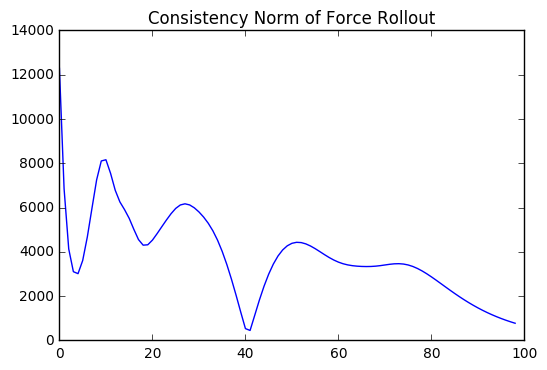

In [46]:
# loss = npy.linalg.norm(force-dmp.target_forces,axis=1)
force_diff = npy.linalg.norm(npy.diff(force,axis=0),axis=1)
plt.plot(range(dmp.time_steps-1),force_diff)
plt.title("Consistency Norm of Force Rollout")
plt.show()

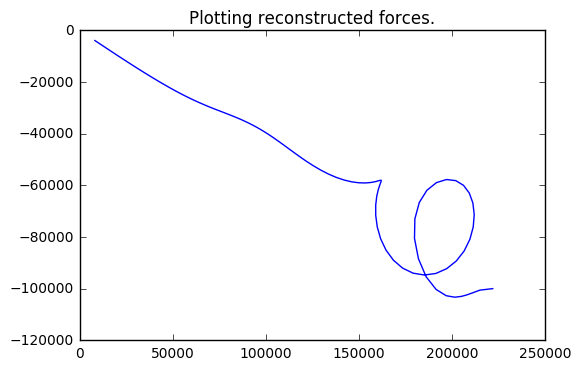

In [47]:
t1=1
t2=1000
# plt.plot(force[:,0],force[:,1])
plt.plot(force[t1:t2,0],force[t1:t2,1])
plt.title("Plotting reconstructed forces.")
plt.show()

In [48]:
start = npy.zeros(2)
# start = copy.deepcopy(dmp.demo_pos[0])
# goal = copy.deepcopy(dmp.demo_pos[99])
# goal = npy.array([2.2,3.6])
goal = npy.ones(2)
dmp.rollout(start, goal)

(0, 0.0, 1.0, 1)
(1, 0.01, 0.92004441462932329, 1)
(2, 0.02, 0.84648172489061402, 1)
(3, 0.03, 0.77880078307140488, 1)
(4, 0.04, 0.71653131057378927, 1)
(5, 0.05, 0.65924063020044366, 1)
(6, 0.06, 0.60653065971263342, 1)
(7, 0.07, 0.55803514577004698, 1)
(8, 0.08, 0.51341711903259202, 1)
(9, 0.09, 0.47236655274101469, 1)
(10, 0.1, 0.43459820850707814, 1)
(11, 0.11, 0.39984965434484732, 1)
(12, 0.12, 0.36787944117144233, 1)
(13, 0.13, 0.33846542510674216, 1)
(14, 0.14, 0.31140322391459757, 1)
(15, 0.15, 0.28650479686019009, 1)
(16, 0.16, 0.26359713811572671, 1)
(17, 0.17, 0.24252107463564865, 1)
(18, 0.18, 0.22313016014842982, 1)
(19, 0.19, 0.20528965757990925, 1)
(20, 0.2, 0.18887560283756177, 1)
(21, 0.21, 0.17377394345044514, 1)
(22, 0.22, 0.15987974607969388, 1)
(23, 0.23, 0.14709646739297677, 1)
(24, 0.24, 0.1353352832366127, 1)
(25, 0.25, 0.12451447144412296, 1)
(26, 0.26, 0.11455884399268769, 1)
(27, 0.27, 0.10539922456186429, 1)
(28, 0.28, 0.096971967864405012, 1)
(29, 0.29, 0.0

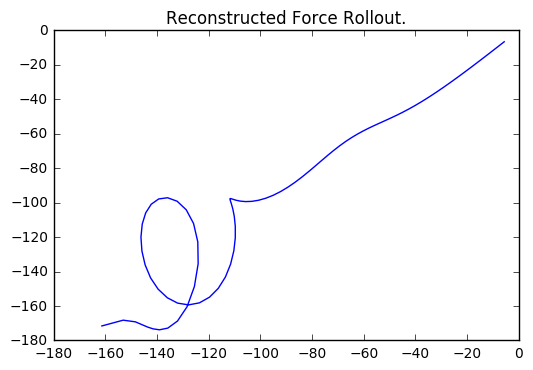

In [49]:
t1 = 0
t2 = dmp.rollout_time
# t2 = 100
# plt.plot(dmp.force_roll[:,0],dmp.force_roll[:,1])
plt.plot(dmp.force_roll[t1:t2,0],dmp.force_roll[t1:t2,1])
# plt.plot(range(100),dmp.force_roll)
# plt.plot(dmp.force_roll[t1:t2,0],dmp.force_roll[t1:t2,1],'o')
plt.title("Reconstructed Force Rollout.")
plt.show()

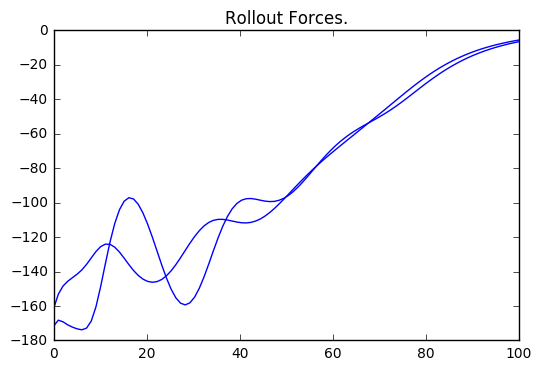

In [50]:

# plt.plot(dmp.acc_roll[:,0],dmp.acc_roll[:,1])

# plt.plot(tr,dmp.vel_roll,'g')
# plt.plot(tr,dmp.acc_roll,'b')
tr2= npy.linspace(0,dmp.rollout_time,dmp.rollout_time)
plt.plot(tr2,dmp.force_roll,'b')
plt.title("Rollout Forces.")
# plt.plot(tr,dmp.pos_roll,'r')

plt.show()
# dmp.pos_roll

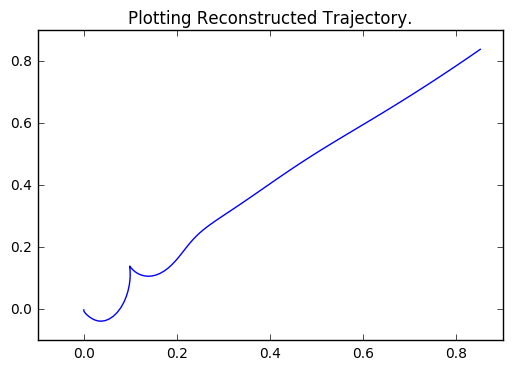

In [51]:
plt.plot(dmp.pos_roll[:,0],dmp.pos_roll[:,1])
plt.title("Plotting Reconstructed Trajectory.")
plt.show()

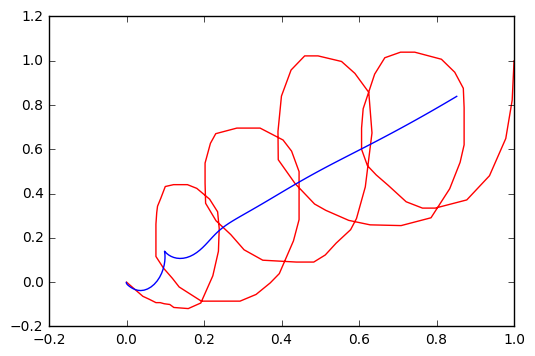

In [52]:
cpos = copy.deepcopy(pos)

cpos -= cpos[0]
cpos /= cpos[dmp.time_steps-1]
dpos = copy.deepcopy(dmp.pos_roll)
# dpos /= dpos[99]
plt.plot(cpos[:,0],cpos[:,1],'r')
plt.plot(dpos[:,0],dpos[:,1],'b')
plt.show()

In [56]:
plt.plot(tr,dmp.vector_phase)

array([  1.00000000e+00,   9.19270292e-01,   8.45057870e-01,
         7.76836596e-01,   7.14122804e-01,   6.56471879e-01,
         6.03475096e-01,   5.54756728e-01,   5.09971380e-01,
         4.68801539e-01,   4.30955328e-01,   3.96164430e-01,
         3.64182192e-01,   3.34781870e-01,   3.07755027e-01,
         2.82910054e-01,   2.60070808e-01,   2.39075368e-01,
         2.19774883e-01,   2.02032521e-01,   1.85722495e-01,
         1.70729172e-01,   1.56946256e-01,   1.44276030e-01,
         1.32628669e-01,   1.21921595e-01,   1.12078900e-01,
         1.03030803e-01,   9.47131568e-02,   8.70669914e-02,
         8.00380986e-02,   7.35766463e-02,   6.76368251e-02,
         6.21765240e-02,   5.71570314e-02,   5.25427610e-02,
         4.83009992e-02,   4.44016737e-02,   4.08171396e-02,
         3.75219838e-02,   3.44928450e-02,   3.17082477e-02,
         2.91484502e-02,   2.67953043e-02,   2.46321272e-02,
         2.26435828e-02,   2.08155730e-02,   1.91351378e-02,
         1.75903638e-02,